# Questions 
* What are the graphs that show val_accuracy
* What's happening with a .compile


# Objectives
YWBAT
* build neural networks and tune hyperparams in Keras
* evaluate NNs


# Agenda
* I will walk through a model and build it 
* Your group will build models to find the best model

# What's the first step for NLP?
* Acquire the data
* Look at and format it for the model
    * format = vectorization
    * what are some types of vectorizations for NLP
        * Bag Of Words - each word is a column and each row gets a word count for each column
        * TFIDF - each word is a column and each row gets a tfidf score for each word
        * TF - 
        * IDF - 
        * Word Embeddings - contextual vectors

In [38]:
import pandas as pd
import numpy as np
import string
import nltk

from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_20newsgroups


import keras
from keras import optimizers
from keras.layers import Dense

from gensim.models import Word2Vec


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("data/nlp_data_train.csv")
df_test = pd.read_csv("data/nlp_data_test.csv")
display(df_train.head(2))
display(df_test.head(2))
df_train.shape, df_test.shape

,article,label,processed_article,cleaned_article_string
0,Note: These trial updates are summarized from ...,4,"['note', 'trial', 'updates', 'summarized', 're...",note trial updates summarized reports idaho st...
1,NaN,3,[],NaN


,article,label,processed_article,cleaned_article_string
0,[ ... ],4,[],NaN
1,"\nonce upon a time, that's exactly what they w...",4,"['upon', 'time', 'exactly', 'would', 'done', '...",upon time exactly would done everyone could go...


((2814, 4), (1873, 4))

In [3]:
bow = CountVectorizer(max_features=5000)

In [4]:
bow_train = bow.fit_transform(df_train["processed_article"])
bow_test = bow.transform(df_test["processed_article"])

In [5]:
bow_train.shape, bow_test.shape

((2814, 5000), (1873, 5000))

In [6]:
len(bow.vocabulary_)

5000

In [110]:
# first one hot encode our target
encoder = OneHotEncoder()

In [111]:
y_train_enc = encoder.fit_transform(df_train["label"].values.reshape(-1, 1))
y_test_enc = encoder.fit_transform(df_test["label"].values.reshape(-1, 1))

In [112]:
y_train_enc.shape, y_test_enc.shape

((2814, 5), (1873, 5))

In [113]:
df_train['label'][:5]

0    4
1    3
2    1
3    4
4    0
Name: label, dtype: int64

In [114]:
y_train_enc.todense()[:5]

matrix([[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])

# Let's build a NN to best predict the outcome

In [115]:
model = keras.Sequential()

In [116]:
model.add(Dense(units=5000, use_bias=False, activation='relu', input_dim=5000))
model.add(Dense(units=6000, use_bias=False, activation='relu', input_dim=5000))
model.add(Dense(units=5, activation='softmax'))

In [117]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 5000)              25000000  
_________________________________________________________________
dense_23 (Dense)             (None, 6000)              30000000  
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 30005     
Total params: 55,030,005
Trainable params: 55,030,005
Non-trainable params: 0
_________________________________________________________________


In [97]:
model_optimizer = optimizers.Adam(lr=0.001)

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=model_optimizer)

# blog on categorical cross entropy
[Click here](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

In [98]:
history = model.fit(bow_train, y_train_enc, epochs=10, batch_size=200, verbose=1)

Epoch 1/10
2814/2814 [==============================] - 17s 6ms/step - loss: 1.2780
Epoch 2/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.1964
Epoch 3/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0982
Epoch 4/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.1232
Epoch 5/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0907
Epoch 6/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0916
Epoch 7/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0796
Epoch 8/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0754
Epoch 9/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0700
Epoch 10/10
2814/2814 [==============================] - 14s 5ms/step - loss: 0.0929


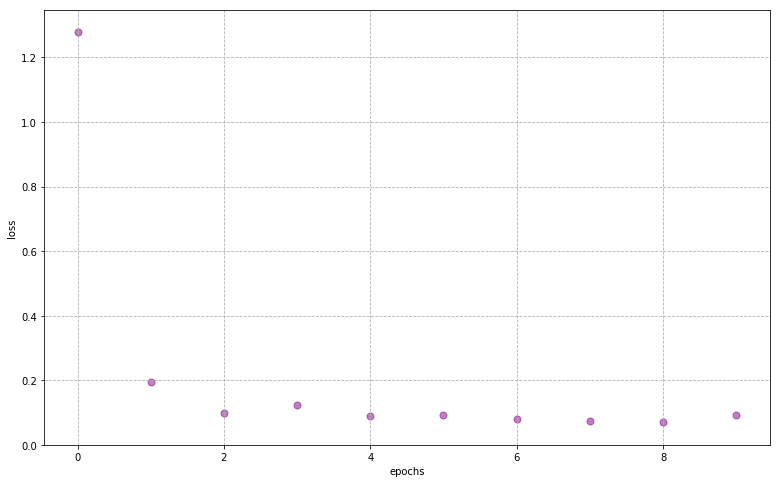

In [99]:
def plot_history(history, figsize=(13, 8), color='purple', s=50, alpha=0.5):
    plt.figure(figsize=figsize)
    plt.grid(zorder=0, linestyle='--')
    plt.scatter(history.epoch, history.history["loss"], c=color, s=s, alpha=alpha)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    
plot_history(history)

In [100]:
y_preds = model.predict(bow_test)
y_preds[:3]

array([[2.0043926e-01, 1.9931869e-01, 2.0099443e-01, 1.9949967e-01,
        1.9974788e-01],
       [2.9143322e-01, 3.1752314e-04, 3.8507734e-03, 1.2061644e-03,
        7.0319235e-01],
       [3.3154685e-02, 5.3331840e-01, 1.0288253e-03, 8.8685848e-02,
        3.4381226e-01]], dtype=float32)

In [101]:
y_pred_labels = np.argmax(y_preds, axis=1)

In [102]:
report = classification_report(df_test['label'], y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       319
           1       0.92      0.91      0.92       395
           2       0.79      0.96      0.87       399
           3       0.85      0.77      0.81       396
           4       0.78      0.74      0.76       364

    accuracy                           0.83      1873
   macro avg       0.83      0.83      0.82      1873
weighted avg       0.83      0.83      0.83      1873



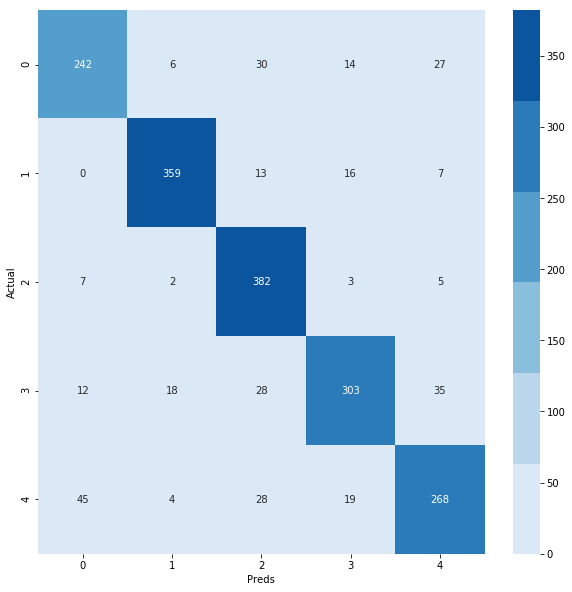

In [103]:
cm = confusion_matrix(df_test['label'], y_pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap=sns.color_palette('Blues'), fmt='0.3g')
plt.xlabel("Preds")
plt.ylabel("Actual")
plt.show()

In [46]:
pca = PCA(n_components=1000)
bow2 = CountVectorizer()

In [53]:
bow_train_2 = bow2.fit_transform(df_train['processed_article'])
bow_test_2 = bow2.transform(df_test['processed_article'])

In [79]:
pca_bow_train = pca.fit_transform(bow_train_2.todense())

In [80]:
pca_bow_test = pca.transform(bow_test_2.todense())

In [81]:
pca_bow_train.shape, pca_bow_test.shape

((2814, 1000), (1873, 1000))

# build a model now

In [82]:
del model_2

In [83]:
model_2 = keras.Sequential()

In [107]:
model_2.add(Dense(input_dim=5000, units=2000, activation='relu', use_bias=False))
model_2.add(Dense(units=3000, activation='relu', use_bias=False))
model_2.add(Dense(units=3000, activation='relu', use_bias=False))
model_2.add(Dense(units=5, activation='softmax', use_bias=False))

In [108]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 2000)              2000000   
_________________________________________________________________
dense_12 (Dense)             (None, 3000)              6000000   
_________________________________________________________________
dense_13 (Dense)             (None, 3000)              9000000   
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 15000     
_________________________________________________________________
dense_18 (Dense)             (None, 2000)              10000     
_________________________________________________________________
dense_19 (Dense)             (None, 3000)              6000000   
_________________________________________________________________
dense_20 (Dense)             (None, 3000)              9000000   
__________

/Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [104]:
opt2 = optimizers.Adam(lr=0.001)
model_2.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=opt2, metrics=['accuracy'])

In [105]:
np.sum(y_train_enc.todense(), axis=0)

matrix([[480., 593., 600., 595., 546.]])

In [109]:
history2 = model_2.fit(x=bow_train, y=y_train_enc, batch_size=200, epochs=20)

ValueError: Please provide as model targets either a single array or a list of arrays. You passed: y=  (0, 4)	1.0
  (1, 3)	1.0
  (2, 1)	1.0
  (3, 4)	1.0
  (4, 0)	1.0
  (5, 4)	1.0
  (6, 3)	1.0
  (7, 1)	1.0
  (8, 3)	1.0
  (9, 4)	1.0
  (10, 3)	1.0
  (11, 2)	1.0
  (12, 0)	1.0
  (13, 4)	1.0
  (14, 4)	1.0
  (15, 4)	1.0
  (16, 2)	1.0
  (17, 3)	1.0
  (18, 4)	1.0
  (19, 1)	1.0
  (20, 4)	1.0
  (21, 2)	1.0
  (22, 1)	1.0
  (23, 1)	1.0
  (24, 2)	1.0
  :	:
  (2789, 0)	1.0
  (2790, 4)	1.0
  (2791, 1)	1.0
  (2792, 0)	1.0
  (2793, 3)	1.0
  (2794, 3)	1.0
  (2795, 2)	1.0
  (2796, 1)	1.0
  (2797, 1)	1.0
  (2798, 0)	1.0
  (2799, 1)	1.0
  (2800, 2)	1.0
  (2801, 0)	1.0
  (2802, 2)	1.0
  (2803, 4)	1.0
  (2804, 4)	1.0
  (2805, 0)	1.0
  (2806, 1)	1.0
  (2807, 3)	1.0
  (2808, 3)	1.0
  (2809, 4)	1.0
  (2810, 0)	1.0
  (2811, 3)	1.0
  (2812, 4)	1.0
  (2813, 3)	1.0

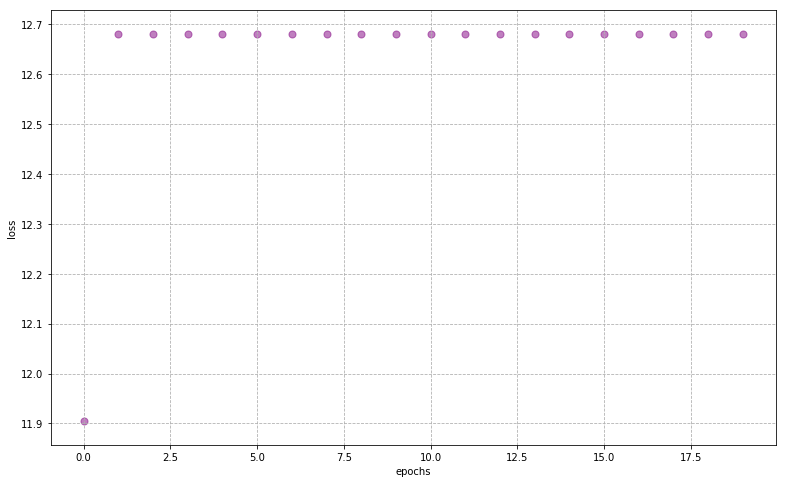

In [89]:
def plot_history(history, figsize=(13, 8), color='purple', s=50, alpha=0.5):
    plt.figure(figsize=figsize)
    plt.grid(zorder=0, linestyle='--')
    plt.scatter(history.epoch, history.history["loss"], c=color, s=s, alpha=alpha)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    
plot_history(history2)

In [90]:
y_test_preds_pca = model_2.predict(pca_bow_test)

In [91]:
cm = confusion_matrix(np.argmax(y_test_enc, axis=1), np.argmax(y_test_preds_pca, axis=1))

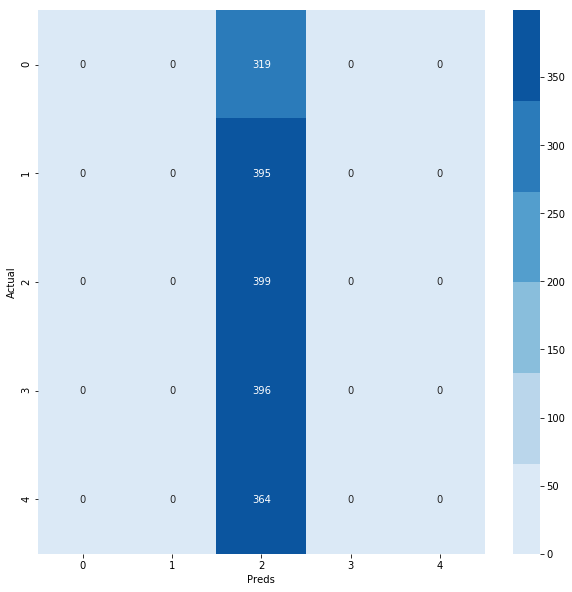

In [92]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap=sns.color_palette('Blues'), fmt='0.3g')
plt.xlabel("Preds")
plt.ylabel("Actual")
plt.show()